# Application of MC $\varepsilon$ greedy and Sarsa-$\lambda$ on the TextFlappyBird-v0 environement
## Kerrian Le Caillec - Reinforcement learning assignment


Loading the environment repo

In [ ]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

### imports

In [ ]:
import os, sys
import time
import text_flappy_bird_gym

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from abc import ABCMeta, abstractmethod
from tqdm import tqdm, trange

## Comparison of the environments

In the next cell, we provide a function that technically serves to convert the screen of TextFlappyBird-screen-v0 to the other env. But in fact, we will not use this function and instead rely directly on the TextFlappyBird-v0.

In [ ]:
def flappy_bird_distance(state):
    """
      Function to convert state of TextFlappyBird-screen into the distance-based env
      Params:
        state: observation in the TextFlappyBird-screen
      Returns:
        x, y: distance to the pipe gap
    """
    state = np.array(state)

    # Find the pos[ ition of Flappy Bird (1)
    bird_position = np.argwhere(state == 1)
    if bird_position.size == 0:
        # In this case the game is over and flappy bird is in state 3 so no calculations
        return 0, 0
    bird_x, bird_y = bird_position[0]

    # Find the line containing the pipe (2)
    pipe_lines = np.argwhere(np.any(state == 2, axis=1))
    if pipe_lines.size == 0:
        raise ValueError("Pipe (2) not found in the state.")

    pipe_line = pipe_lines[0][0]

    # Calculate the center of the pipe gap (average x positions of 0 in the pipe line)
    gap_positions = np.where(state[pipe_line] == 0)[0]
    if gap_positions.size == 0:
        raise ValueError("No gap (0) found in the pipe line.")

    gap_center_x = np.floor(np.mean(gap_positions))
    gap_center_y = pipe_line

    # Calculate the distance (x, y)
    distance_x = gap_center_x - bird_y
    distance_y = gap_center_y - bird_x

    return int(distance_y), int(distance_x)

## Game example

In [ ]:
# initiate environment
print("Distance Env")
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
print(obs)
print(env.observation_space, env.action_space)

print("Screen Env")
env = gym.make("TextFlappyBird-screen-v0", height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
print(env.observation_space, env.action_space)
while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
    obs, reward, done, _, info = env.step(action)
    print(flappy_bird_distance(obs))
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    # If player is dead break
    if done:
        break

env.close()


## MC $\epsilon$-greedy agent

In [ ]:
class BaseAgent:
    """Implements the agent template."""
    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, *args, **kwargs):
        """Setup for the agent called when the experiment first starts."""
        pass

    @abstractmethod
    def get_policy(self, state, **kwargs):
        """Get the Agent policy in the given state"""
        pass

    @abstractmethod
    def get_action(self, state, **kwargs):
        """Get the Agent action in the given state"""
        pass
    @abstractmethod
    def reset_agent(self):
        """Cleanup done after the agent ends."""
        pass


class MCEpsilonGreedy(BaseAgent):
    """
    Monte Carlo agent using epsilon-greedy policy for action selection.
    """
    def __init__(self):
        super().__init__()
        self.q_values = None  # Q-values for state-action pairs
        self.returns_memory = None  # Memory to store returns for updating policy
        self.policy = None  # Policy for action selection
        self.epsilon = None  # Exploration parameter
        self.learning_rate = None  # Learning rate (alpha)
        self.discount_factor = None  # Discount factor (gamma)
        self.num_actions = None  # Number of possible actions
        self.num_states = None  # Number of possible states

    def agent_init(self, num_states, num_actions, epsilon=0.1, learning_rate=0.02, discount_factor=1.0):
        """
        Initialize the agent with the required parameters and Q-values.

        Args:
            num_states: Total number of states in the environment.
            num_actions: Total number of actions in the environment.
            epsilon: Exploration rate for epsilon-greedy policy.
            learning_rate: Step size for Q-value updates.
            discount_factor: Discount factor for future rewards.
        """
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.num_actions = num_actions
        self.num_states = num_states
        self.q_values = np.random.uniform(low=-1, high=1, size=(self.num_states, self.num_actions))

    def get_policy(self, state, greedy=False):
        """
        Calculate the action probability distribution for a given state.

        Args:
            state: Current state of the agent.
            greedy: If True, use a greedy policy.

        Returns:
            A probability distribution over actions.
        """
        optimal_action = np.argmax(self.q_values[state])
        if greedy:
            policy = np.zeros(self.num_actions)
            policy[optimal_action] = 1.0
            return policy

        policy = np.ones(self.num_actions) * self.epsilon / self.num_actions
        policy[optimal_action] += (1.0 - self.epsilon)
        return policy

    def get_action(self, observation, greedy=False):
        """
        Select an action based on the current policy and state.

        Args:
            observation: The current state of the environment.
            greedy: If True, select actions greedily.

        Returns:
            The action selected.
        """
        state = observation
        action = np.random.choice(np.arange(self.num_actions), p=self.get_policy(state, greedy=greedy))
        return action

    def update_q_values(self, episode):
        """
        Perform Monte Carlo updates on Q-values based on the observed episode.

        Args:
            episode: A list of (state, action, reward) tuples from an episode.
        """
        cumulative_return = 0
        visited_pairs = set()  # To ensure first-visit Monte Carlo updates
        for state, action, reward in reversed(episode):
            cumulative_return = reward + self.discount_factor * cumulative_return

            # Update Q-value only for first visit to (state, action)
            if (state, action) not in visited_pairs:
                visited_pairs.add((state, action))
                self.q_values[state, action] += self.learning_rate * (cumulative_return - self.q_values[state, action])

    def reset_agent(self):
        """
        Reset the agent's memory and Q-values.
        """
        self.q_values = None
        self.returns_memory = None

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
number_states = nh * nw
width_offset = env.observation_space[1].start
total_episodes = 15000

# Function to preprocess the state into a single index
def state_to_index(state):
    return nw * state[0] + state[1] + width_offset

# Function to apply geometric smoothing to a list
def smooth_data(data, coefficient=0.95):
    smoothed = [data[0]]
    for idx in range(1, len(data)):
        smoothed.append(coefficient * smoothed[-1] + (1 - coefficient) * data[idx])
    return smoothed

## Sarsa($\lambda$) definition

In [ ]:
class SarsaLambda(BaseAgent):
    def __init__(self):
        super().__init__()
        self.q_values = None
        self.returns = None
        self.policy = None
        self.epsilon = None
        self.learning_rate = None
        self.discount_factor = None
        self.num_actions = None

    @classmethod
    def state_to_index(cls, state, width, width_offset):
        return width * state[0] + state[1] + width_offset

    def agent_init(self, num_states, num_actions, epsilon=0.1, learning_rate=0.02, discount_factor=1.0, lbd=1.0):
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.lbd = lbd
        self.num_actions = num_actions
        self.num_states = num_states
        self.q_values = np.random.uniform(low=-1, high=1, size=(self.num_states, self.num_actions))
        self.eligibility_traces = np.zeros((self.num_states, self.num_actions))

    def get_policy(self, state, greedy=False):
        best_action = np.argmax(self.q_values[state])
        if greedy:
            policy_s = np.zeros(self.num_actions)
            policy_s[best_action] = 1.0
            return policy_s
        policy_s = np.ones(self.num_actions) * self.epsilon / self.num_actions
        policy_s[best_action] += (1.0 - self.epsilon)
        return policy_s

    def get_action(self, observation, greedy=False):
        state = observation
        action = np.random.choice(np.arange(self.num_actions), p=self.get_policy(state, greedy=greedy))
        return action

    def train_one_episode(self, env, screen=False):
        obs, _ = env.reset()
        if screen:
            obs = flappy_bird_distance(obs)

        done = False
        step_count = 0
        processed_obs = self.state_to_index(obs, nw, width_offset)
        action = self.get_action(processed_obs)

        while not done:
            next_obs, reward, done, _, info = env.step(action)
            if screen:
                next_obs = flappy_bird_distance(next_obs)
            processed_next_obs = self.state_to_index(next_obs, nw, width_offset)
            next_action = self.get_action(processed_next_obs)

            delta = (
                reward
                + self.discount_factor * self.q_values[processed_next_obs, next_action]
                - self.q_values[processed_obs, action]
            )

            self.eligibility_traces[processed_obs, action] += 1  # Accumulating traces
            self.q_values += self.learning_rate * delta * self.eligibility_traces
            self.eligibility_traces *= self.discount_factor * self.lbd

            step_count += 1
            action = next_action
            processed_obs = processed_next_obs

        return step_count

    def agent_cleanup(self):
        self.q_values = None
        self.returns = None
        self.eligibility_traces = None



# Preliminary study on training loop to check whether the agents work
## Training loop

We train both models in this loop

In [ ]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
number_states = nh * nw
width_offset = env.observation_space[1].start
num_episodes = 15000

# Initialize the Sarsa Lambda agent
sarsa_agent = SarsaLambda()
sarsa_agent.agent_init(number_states, 2, epsilon=0.05, learning_rate=0.1, discount_factor=0.9, lbd=0.2)
# Initialize the Monte Carlo agent with epsilon-greedy policy
mc_agent = MCEpsilonGreedy()
mc_agent.agent_init(number_states, 2, epsilon=0.07, learning_rate=0.1, discount_factor=0.8)

progress_bar = trange(total_episodes)
lengths = {"sarsa": [], "mc": []}

# Training loop for the agent
for ep in progress_bar:
    # Load sarsa lambda model
    state, _ = env.reset()
    sarsa_len = sarsa_agent.train_one_episode(env)
    lengths["sarsa"].append(sarsa_len)
    # Load MC eps greedy model
    state, _ = env.reset()
    done = False
    steps = 0
    trajectory = []
    while not done:
        state = state_to_index(state)
        selected_action = mc_agent.get_action(state)

        # Apply the action and observe the next state and reward
        next_state, reward, done, _, info = env.step(selected_action)
        trajectory.append((state, selected_action, reward))
        state = next_state
        steps += 1

    # Update Q-values based on the episode trajectory
    mc_agent.update_q_values(trajectory)
    lengths["mc"].append(steps)
    progress_bar.set_description(str(steps), refresh=False)


163: 100%|██████████| 15000/15000 [01:16<00:00, 197.27it/s]


## Training plots

We display the number of steps per episode for the different models.

Text(0, 0.5, '#Steps')

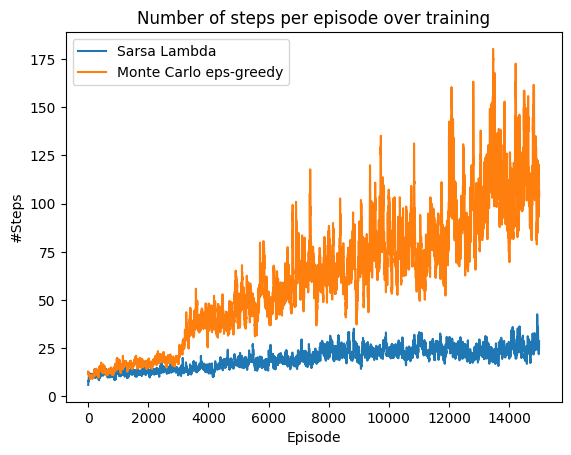

In [ ]:
plt.plot(smooth_data(lengths["sarsa"]), label="Sarsa Lambda")
plt.plot(smooth_data(lengths["mc"]), label="Monte Carlo eps-greedy")
plt.legend()
plt.title("Number of steps per episode over training")
plt.xlabel("Episode")
plt.ylabel("#Steps")

 We look at how the model performs by using a greedy action selection i.e. the model chooses as an action the argmax of the policy.

In [ ]:
def greedy_mean_steps(agents, nb_exps, metric_name):
    for value, agent in agents.items():
      lengths = []
      for _ in range(nb_exps):
          obs,_ = env.reset()
          i = 0
          done = False
          # We force the number of step to be lower than 1000 for computational reasons
          while not done and i < 1000:
              i += 1
              processed_obs = state_to_index(obs)
              action = agent.get_action(processed_obs, greedy=True)
              obs, reward, done, _, info = env.step(action)

          lengths.append(i)
          env.close()
      print(f"{metric_name} : {value}: Mean steps {sum(lengths) / nb_exps}, Std steps: {np.std(lengths)}")

agents = {"Sarsa": sarsa_agent, "MC epsilon": mc_agent}
greedy_mean_steps(agents, 100, "Greedy")

Greedy : Sarsa: Mean steps 31.99, Std steps: 29.295902443857234
Greedy : MC epsilon: Mean steps 899.68, Std steps: 230.61577916526008


## State-value heatmaps

### MC $\epsilon$-greedy state-value plots

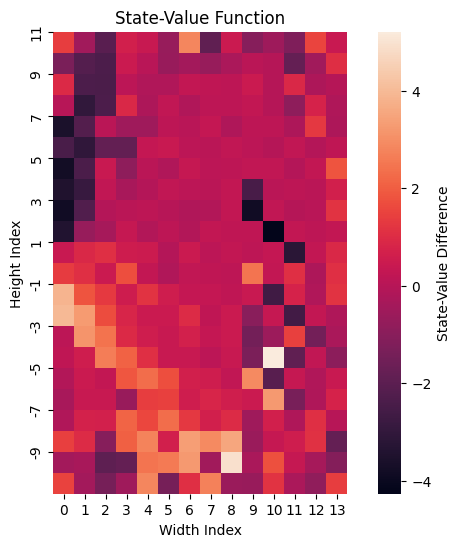

In [ ]:
import seaborn as sns

nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
number_states = nh * nw
def get_2D_Q_difference(Q):
    """
    Compute the 2D representation of the Q-value differences between actions.

    Args:
        Q: Q-table with shape (num_states, num_actions).

    Returns:
        A 2D array representing the difference between Q-values of actions 1 and 0.
    """
    Q_2D_diff = np.zeros((nh, nw))
    for height_idx in range(nh):
        for width_idx in range(nw):
            state_idx = nw * height_idx + width_idx
            Q_2D_diff[height_idx, width_idx] = Q[state_idx, 1] - Q[state_idx, 0]
    return Q_2D_diff

Q_mc = mc_agent.q_values
Q_2D_mc = get_2D_Q_difference(Q_mc)
num_rows, num_cols = Q_2D_mc.shape

def plot_2D_Q(Q_2D, title="State-Value Function", offset=0):
    """
    Plot the 2D representation of Q-value differences.

    Args:
        Q_2D: 2D array of Q-value differences.
        title: Title of the plot.
        cmap: Colormap for the plot.
        offset: Offset for the y-axis labels.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(Q_2D, annot=False, cbar_kws={'label': 'State-Value Difference'}, square=True)
    y_ticks = np.arange(0, num_cols, 2)  # Ticks every 2 units
    y_labels = [f"{-tick - offset}" for tick in y_ticks]  # Adjust y-labels with offset
    plt.yticks(y_ticks, y_labels)
    plt.xlabel("Width Index")
    plt.ylabel("Height Index")
    plt.title(title)
    plt.show()

plot_2D_Q(Q_2D_mc.transpose(), offset=width_offset)


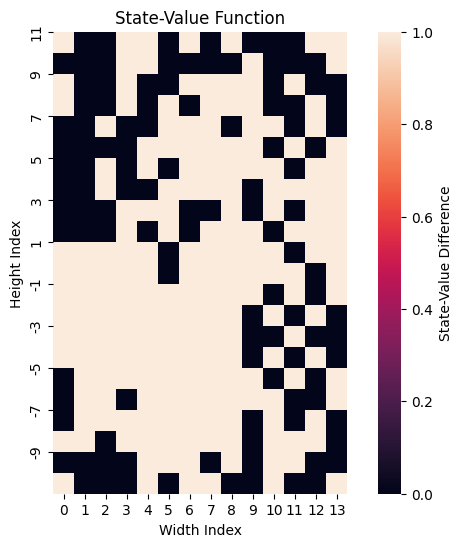

In [ ]:
plot_2D_Q(Q_2D_mc.transpose()>=0, offset=width_offset)

### Sarsa($\lambda$) state-value plot

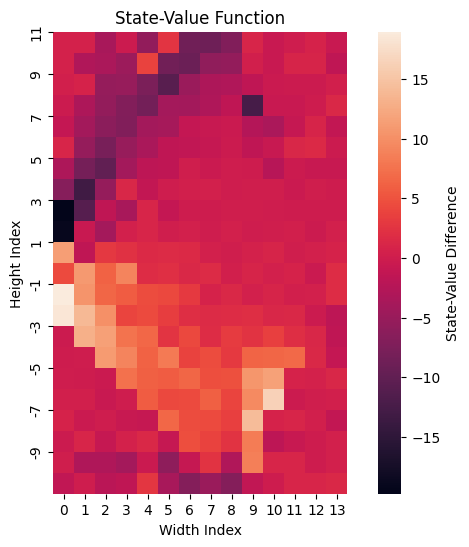

In [ ]:
Q_sc = sarsa_agent.q_values
Q_2D_sc = get_2D_Q_difference(Q_sc)
nx, ny = Q_2D_sc.shape

plot_2D_Q(Q_2D_sc.transpose(), offset=width_offset)


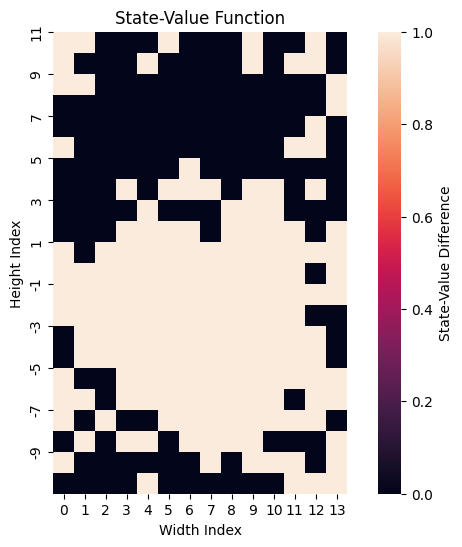

In [ ]:
plot_2D_Q(Q_2D_sc.transpose()>=0, offset=width_offset)

- The models show similar results in terms of the action chosen given the state of the model
- When the bird is below the pipe gap, the model learn to usually flap when sufficiently far away of the width index from it
- On the other hand, the bird is in idle mode when above the pipe gap

## Change env for same agent


In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 15, pipe_gap = 2)
greedy_mean_steps(agents, 100, "15x15x2")
env = gym.make('TextFlappyBird-v0', height = 10, width = 10, pipe_gap = 6)
greedy_mean_steps(agents, 100, "10x10x6")

15x15x2 : Sarsa: Mean steps 20.75, Std steps: 9.675096898739568
15x15x2 : MC epsilon: Mean steps 28.26, Std steps: 17.132787280533194
10x10x6 : Sarsa: Mean steps 150.8, Std steps: 149.78771645231797
10x10x6 : MC epsilon: Mean steps 1000.0, Std steps: 0.0


- Wider pipe gap means that the pre-trained agents are able to better perform this is visble as the mean number of actions is usually higher than previously.
- On the other hand, a narrower pipe gap leads to worse overall performances from the two models.

# Parameter sweeps

### Monte-Carlo $\varepsilon$ Agent parameters

In [ ]:
episodes = 15000

In [ ]:
def plot_sweep(logs, metric_name):
    """
    Utilitary function to plot the length of episode over training for different agents.
    Arguments:
        logs: dictionary containing the logs of different agents
        metric_name: name of the metric to be plotted
    """
    for name, log in logs.items():
        plt.plot(smooth_data(log, coefficient=0.99), label=f"{metric_name} : {name}")
    plt.legend()
    plt.title("Length of episode over training")
    plt.xlabel("Episode")
    plt.ylabel("#Steps")
    plt.show()

### $\varepsilon$ sweep

23: 100%|██████████| 15000/15000 [00:21<00:00, 683.27it/s]


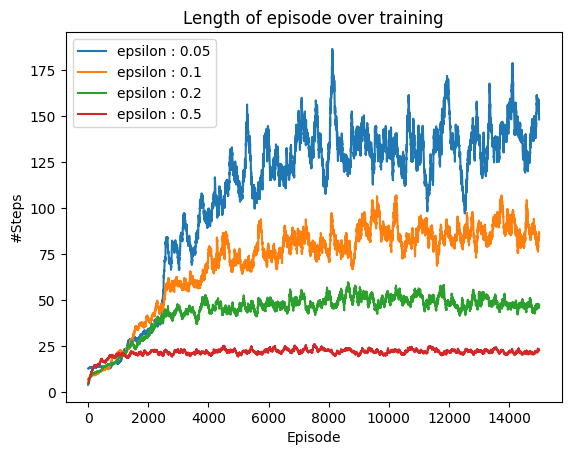

In [ ]:
epsilons = [0.05, 0.1, 0.2, 0.5]
logs = {}
agents = {}
for epsilon in epsilons:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    nh, nw = tuple(discrete_space.n for discrete_space in env.observation_space)
    width_offset = env.observation_space[1].start
    number_states = nh * nw
    mc_agent = MCEpsilonGreedy()
    mc_agent.agent_init(number_states, 2, epsilon=epsilon, learning_rate=0.1, discount_factor=0.9)
    pbar = trange(episodes)
    logs_mc = []
    for episode in pbar:
        episode_log = []
        obs,_ = env.reset()
        done=False
        i=0
        while not done:
            processed_obs = state_to_index(obs)
            action = mc_agent.get_action(processed_obs)
            # Apply action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            episode_log.append((processed_obs, action, reward))
            i+=1
        mc_agent.update_q_values(episode_log)
        logs_mc.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[epsilon] = logs_mc
    agents[epsilon] = mc_agent
plot_sweep(logs, "epsilon")

In [ ]:
greedy_mean_steps(agents, 1000, "epsilon")

epsilon : 0.05: Mean steps 224.953, Std steps: 217.60354498720835
epsilon : 0.1: Mean steps 1000.0, Std steps: 0.0
epsilon : 0.2: Mean steps 1000.0, Std steps: 0.0
epsilon : 0.5: Mean steps 165.259, Std steps: 147.9910467528357


Smaller value of epsilon are retained here as the training curve of epsilon=0.05 yields interesting results in episode duration.

### $\alpha$ sweep

73: 100%|██████████| 15000/15000 [01:41<00:00, 147.64it/s] 


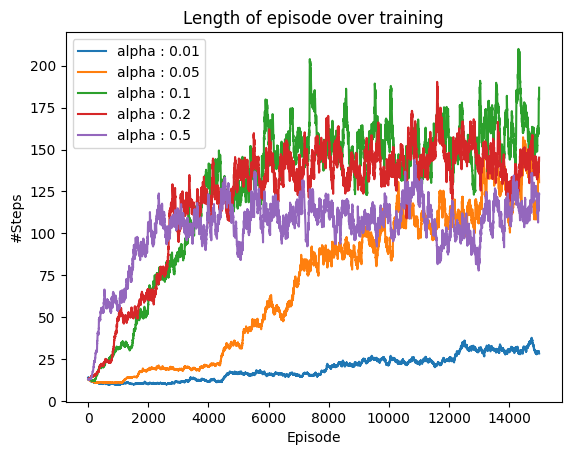

In [ ]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]
logs = {}
agents = {}
for alpha in alphas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    mc_agent = MCEpsilonGreedy()
    mc_agent.agent_init(number_states, 2, epsilon=0.05, learning_rate=alpha, discount_factor=0.9)
    pbar = trange(episodes)
    logs_mc = []
    for episode in pbar:
        episode_log = []
        obs,_ = env.reset()
        done=False
        i=0
        while not done:
            processed_obs = state_to_index(obs)
            action = mc_agent.get_action(processed_obs)
            # Apply action and return new observation of the environment
            obs, reward, done, _, info = env.step(action)
            episode_log.append((processed_obs, action, reward))
            i+=1
        mc_agent.update_q_values(episode_log)
        logs_mc.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[alpha] = logs_mc
    agents[alpha] = mc_agent
plot_sweep(logs, "alpha")

In [ ]:
greedy_mean_steps(agents, 1000, "alpha")

alpha : 0.01: Mean steps 42.474, Std steps: 40.139996562032735
alpha : 0.05: Mean steps 207.168, Std steps: 188.1945795606239
alpha : 0.1: Mean steps 632.429, Std steps: 351.4514147915754
alpha : 0.2: Mean steps 949.48, Std steps: 174.65654754403
alpha : 0.5: Mean steps 197.902, Std steps: 195.06348298951292


For alpha values between [0.1, 0.5], we have similar results, we will use alpha=0.2 in the next section.

### $\gamma$ sweep

63: 100%|██████████| 15000/15000 [01:12<00:00, 206.69it/s]


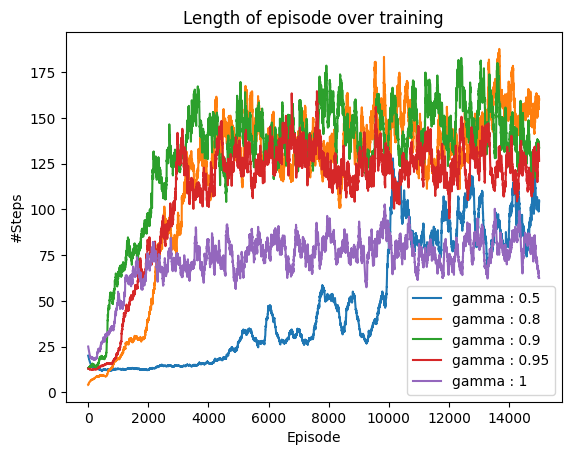

In [ ]:
gammas=[0.5, 0.8, 0.9, 0.95, 1]
logs = {}
agents = {}
for gamma in gammas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    mc_agent = MCEpsilonGreedy()
    mc_agent.agent_init(number_states, 2, epsilon=0.05, learning_rate=0.2, discount_factor=gamma)
    pbar = trange(episodes)
    logs_mc = []
    for episode in pbar:
        episode_log = []
        obs,_ = env.reset()
        done=False
        i=0
        while not done:
            processed_obs = state_to_index(obs)
            action = mc_agent.get_action(processed_obs)
            obs, reward, done, _, info = env.step(action)
            episode_log.append((processed_obs, action, reward))
            i += 1
        mc_agent.update_q_values(episode_log)
        logs_mc.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[gamma] = logs_mc
    agents[gamma] = mc_agent
plot_sweep(logs, "gamma")

In [ ]:
greedy_mean_steps(agents, 1000, "gamma")

gamma : 0.5: Mean steps 162.487, Std steps: 136.35030557721535
gamma : 0.8: Mean steps 1000.0, Std steps: 0.0
gamma : 0.9: Mean steps 180.252, Std steps: 183.349869091854
gamma : 0.95: Mean steps 1000.0, Std steps: 0.0
gamma : 1: Mean steps 94.601, Std steps: 81.48438990996988


High gamma not equal to one but close to one are the best values in terms of performance here.

## Sarsa($\lambda$) parameters sweep

In [ ]:
episodes = 5000

### $\varepsilon$ sweep

41: 100%|██████████| 5000/5000 [00:07<00:00, 674.96it/s]


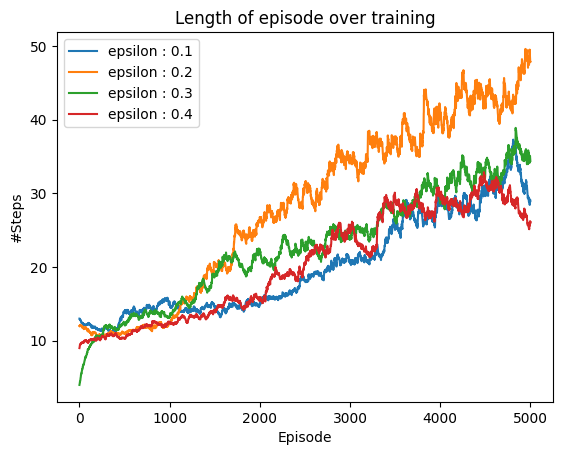

In [ ]:
epsilons = [0.1, 0.2, 0.3, 0.4]
logs = {}
agents = {}
for epsilon in epsilons:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    sarsa_agent = SarsaLambda()
    sarsa_agent.agent_init(number_states, 2, epsilon=epsilon, learning_rate=0.1, discount_factor=0.9, lbd=0.3)
    pbar = trange(episodes)
    logs_sr = []
    for episode in pbar:
        i = sarsa_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[epsilon] = logs_sr
    agents[epsilon] = sarsa_agent
plot_sweep(logs, "epsilon")

In [ ]:
greedy_mean_steps(agents, 1000, "epsilon")

epsilon : 0.1: Mean steps 67.063, Std steps: 57.447219523663634
epsilon : 0.2: Mean steps 200.297, Std steps: 203.24015545900372
epsilon : 0.3: Mean steps 599.424, Std steps: 361.55568066896694
epsilon : 0.4: Mean steps 622.687, Std steps: 353.2312231824928


Epsilon equal to 0.2 yields the best results in the training plot, for higher values we may have high variance of the duration of an episode meaning that it may be more uncertain.

### $\alpha$ sweep

61: 100%|██████████| 5000/5000 [00:21<00:00, 237.59it/s] 


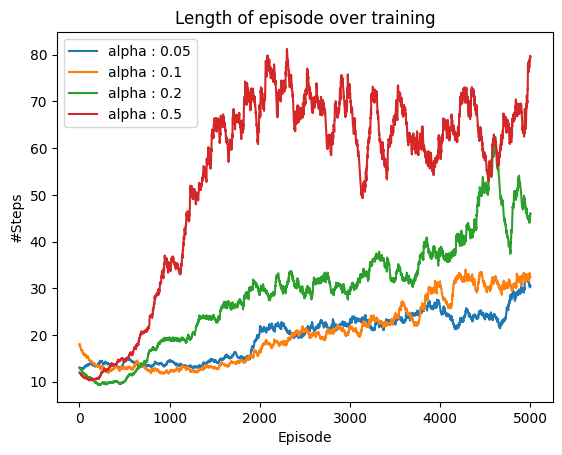

In [ ]:
alphas=[0.05, 0.1, 0.2, 0.5]
logs = {}
agents = {}

for alpha in alphas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    sarsa_agent = SarsaLambda()
    sarsa_agent.agent_init(number_states, 2, epsilon=0.1, learning_rate=alpha, discount_factor=0.9, lbd=0.3)
    pbar = trange(episodes)
    logs_sr = []
    for episode in pbar:
        i = sarsa_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[alpha] = logs_sr
    agents[alpha] = sarsa_agent
plot_sweep(logs, "alpha")

In [ ]:
greedy_mean_steps(agents, 1000, "alpha")

alpha : 0.05: Mean steps 50.435, Std steps: 49.28697368473743
alpha : 0.1: Mean steps 58.402, Std steps: 47.38329237188991
alpha : 0.2: Mean steps 257.373, Std steps: 237.42190688940227
alpha : 0.5: Mean steps 212.656, Std steps: 202.9933241857968


Higher alpha are usually better for the model here with 0.2 achieving the best performance in greedy action selection mode.

### $\gamma$ sweep

13: 100%|██████████| 5000/5000 [00:08<00:00, 593.56it/s]


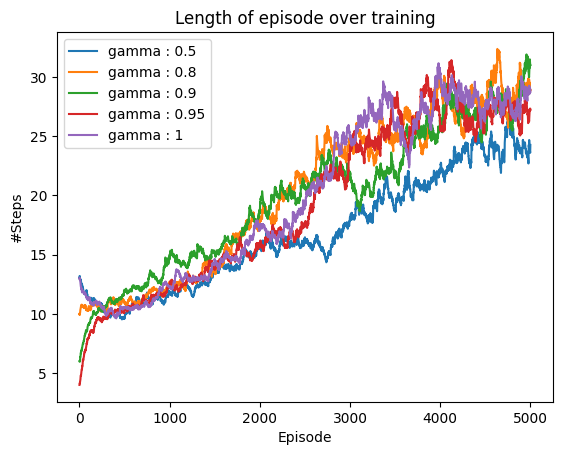

In [ ]:
gammas=[0.5, 0.8, 0.9, 0.95, 1]
logs = {}
agents = {}
for gamma in gammas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    sarsa_agent = SarsaLambda()
    sarsa_agent.agent_init(number_states, 2, epsilon=epsilon, learning_rate=0.1, discount_factor=gamma, lbd=0.3)
    pbar = trange(episodes)
    logs_sr = []
    for episode in pbar:
        i = sarsa_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[gamma] = logs_sr
    agents[gamma] = sarsa_agent
plot_sweep(logs, "gamma")

In [ ]:
greedy_mean_steps(agents, 1000, "gamma")

gamma : 0.5: Mean steps 293.564, Std steps: 257.32125816574114
gamma : 0.8: Mean steps 527.429, Std steps: 341.9773105909221
gamma : 0.9: Mean steps 844.699, Std steps: 301.8998615418696
gamma : 0.95: Mean steps 370.327, Std steps: 306.6633693009323
gamma : 1: Mean steps 556.961, Std steps: 357.03484070745816


Gamma around [0.8, 0.95] gives satisfying results.
The plot have converged around the 4000th episode in the training plot.

### $\lambda$ sweep

23: 100%|██████████| 5000/5000 [00:05<00:00, 945.37it/s]


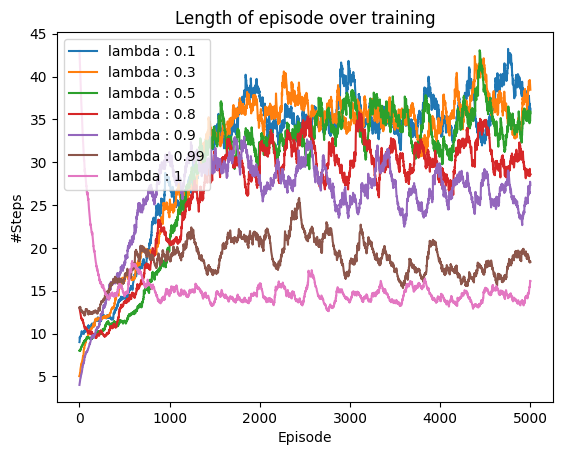

In [ ]:
lambdas=[0.1,0.3,0.5,0.8,0.9,0.99,1]
logs = {}
agents = {}
for lbd in lambdas:
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    sarsa_agent = SarsaLambda()
    sarsa_agent.agent_init(number_states, 2, epsilon=0.3, learning_rate=0.2, discount_factor=0.99, lbd=lbd)
    pbar = trange(episodes)
    logs_sr = []
    for episode in pbar:
        i = sarsa_agent.train_one_episode(env)
        logs_sr.append(i)
        pbar.set_description(str(i), refresh=False)
    logs[lbd] = logs_sr
    agents[lbd] = sarsa_agent
plot_sweep(logs, "lambda")

In [ ]:
greedy_mean_steps(agents, 1000, "lambda")

lambda : 0.1: Mean steps 588.714, Std steps: 359.4657121395586
lambda : 0.3: Mean steps 970.194, Std steps: 153.1178642876134
lambda : 0.5: Mean steps 713.323, Std steps: 335.9824201814732
lambda : 0.8: Mean steps 51.275, Std steps: 49.34723269850094
lambda : 0.9: Mean steps 89.996, Std steps: 72.27018738041296
lambda : 0.99: Mean steps 33.346, Std steps: 21.040111311492627
lambda : 1: Mean steps 60.095, Std steps: 51.67492597962768


Lower lambda gives better results.

### Overall retained model

Based on the hyperparameter sweep, we have decided to retain the following agents as the best ones:

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
episodes = 15000
# Initialize the Monte Carlo agent with epsilon-greedy policy
mc_agent = MCEpsilonGreedy()
mc_agent.agent_init(number_states, 2, epsilon=0.05, learning_rate=0.2, discount_factor=0.8)

# Initialize the Sarsa lambda agent
sarsa_agent = SarsaLambda()
sarsa_agent.agent_init(number_states, 2, epsilon=0.2, learning_rate=0.05, discount_factor=0.95, lbd=0.1)
pbar = trange(episodes)

progress_bar = trange(total_episodes)
lengths = {"sarsa": [], "mc": []}

# Training loop for the agent
for ep in progress_bar:
    # Load sarsa lambda model
    state, _ = env.reset()
    sarsa_len = sarsa_agent.train_one_episode(env)
    lengths["sarsa"].append(sarsa_len)
    # Load MC eps greedy model
    state, _ = env.reset()
    done = False
    steps = 0
    trajectory = []
    while not done:
        state = state_to_index(state)
        selected_action = mc_agent.get_action(state)

        # Apply the action and observe the next state and reward
        next_state, reward, done, _, info = env.step(selected_action)
        trajectory.append((state, selected_action, reward))
        state = next_state
        steps += 1

    # Update Q-values based on the episode trajectory
    mc_agent.update_q_values(trajectory)
    lengths["mc"].append(steps)
    progress_bar.set_description(str(steps), refresh=False)




  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [40:14<?, ?it/s]


9:   0%|          | 16/15000 [00:00<01:36, 154.96it/s]

13:   0%|          | 57/15000 [00:00<00:50, 298.39it/s]

13:   1%|          | 102/15000 [00:00<00:42, 351.69it/s]

13:   1%|          | 138/15000 [00:00<00:46, 322.73it/s]

13:   1%|          | 171/15000 [00:00<00:50, 293.51it/s]

13:   1%|▏         | 201/15000 [00:00<00:53, 276.16it/s]

13:   2%|▏         | 231/15000 [00:00<00:53, 278.02it/s]

13:   2%|▏         | 267/15000 [00:00<00:48, 301.20it/s]

13:   2%|▏         | 298/15000 [00:01<00:52, 282.56it/s]

23:   2%|▏         | 333/15000 [00:01<00:48, 300.75it/s]

13:   2%|▏         | 368/15000 [00:01<00:46, 312.86it/s]

4:   3%|▎         | 400/15000 [00:01<00:54, 266.63it/s] 

4:   3%|▎         | 429/15000 [00:01<01:11, 202.69it/s]

4:   3%|▎         | 457/15000 [00:01<01:06, 219.12it/s]

13:   3%|▎         | 482/15000 [00:01<01:05, 221.76it/s]

8:   3%|▎         | 515/15000 [00:01<00:58, 248

In [ ]:
agents = {"Sarsa": sarsa_agent, "MC epsilon": mc_agent}
greedy_mean_steps(agents, 1000, "Overall")

Overall : Sarsa: Mean steps 1000.0, Std steps: 0.0
Overall : MC epsilon: Mean steps 512.814, Std steps: 330.42370890116223


Text(0, 0.5, '#Steps')

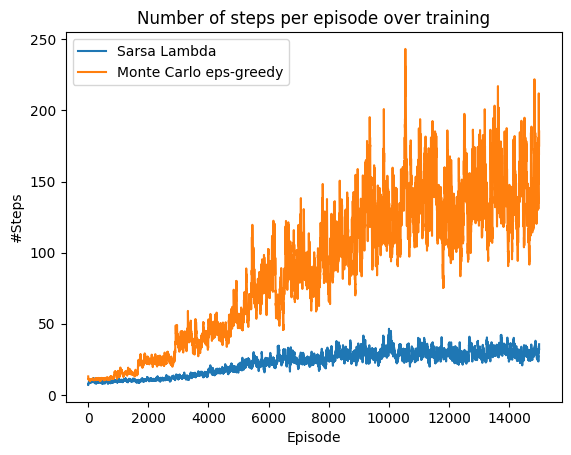

In [ ]:
plt.plot(smooth_data(lengths["sarsa"]), label="Sarsa Lambda")
plt.plot(smooth_data(lengths["mc"]), label="Monte Carlo eps-greedy")
plt.legend()
plt.title("Number of steps per episode over training")
plt.xlabel("Episode")
plt.ylabel("#Steps")

The two previous models show th best performance overall with high number of steps in episode meaning that flappy bird achieves a correct move set for more >500 times in the case of the Sarsa-$\lambda$ model (over multiple runs) and more than >500 for the MC-$\epsilon$ greedy model.